In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.data

### Visualizing dyad

In [2]:
X = skimage.data.brick()
print(f"Shape of the image: {X.shape}.")

Shape of the image: (512, 512).


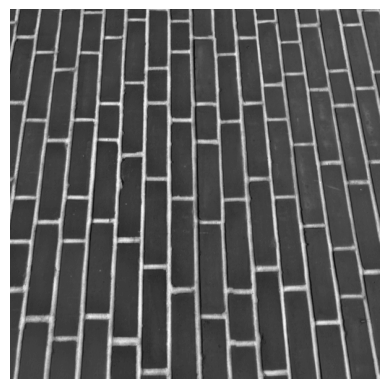

In [3]:
plt.imshow(X, cmap="gray")
plt.axis('off')
plt.show()

In [4]:
#compute its SVD
U, s, VT = np.linalg.svd(X, full_matrices = False)
print(f"dimensions: {U.shape}, {s.shape}, {VT.shape}")

dimensions: (512, 512), (512,), (512, 512)


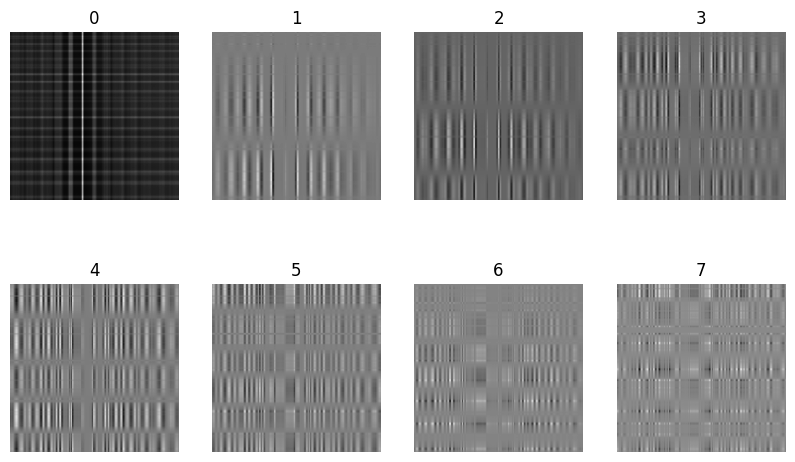

In [5]:
# visualize some dyads
def k_dyad(U, s, VT, k):
    u_k = U[:, k].reshape(-1,1)
    v_k = VT[k, :].reshape(-1,1)
    d_k = s[k] * (u_k  @ v_k.T)
    return d_k
dyads = [k_dyad(U, s, VT, k) for k in range(8)]

_, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flatten()
for i, (dyad, ax) in enumerate(zip(dyads, axs)):
    ax.imshow(dyad, cmap='gray')
    ax.axis('off')
    ax.set_title(i)
plt.show()


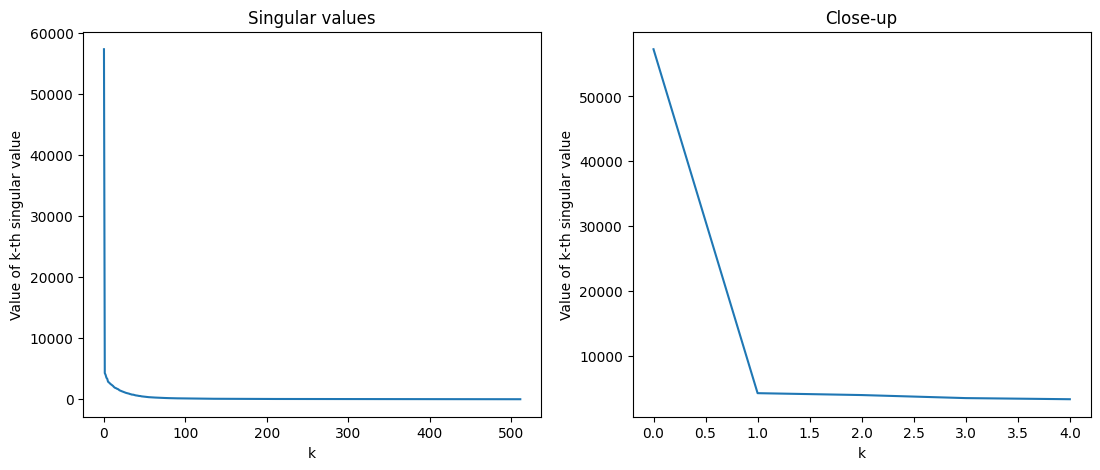

In [6]:
# Plot the distribution of singular values
_, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].plot(s)
axs[0].set_title("Singular values")
axs[0].set_xlabel("k")
axs[0].set_ylabel("Value of k-th singular value")

axs[1].plot(s[:5])
axs[1].set_title("Close-up")
axs[1].set_xlabel("k")
axs[1].set_ylabel("Value of k-th singular value")
plt.show()

# The difference between the first singular element and the second element is enourmus

In [7]:
s[:10] # as we can see

array([57279.54969119,  4277.0490329 ,  3986.00044673,  3517.02898657,
        3344.25778347,  2866.91899903,  2759.57985237,  2622.15811397,
        2497.07195775,  2402.77264878])

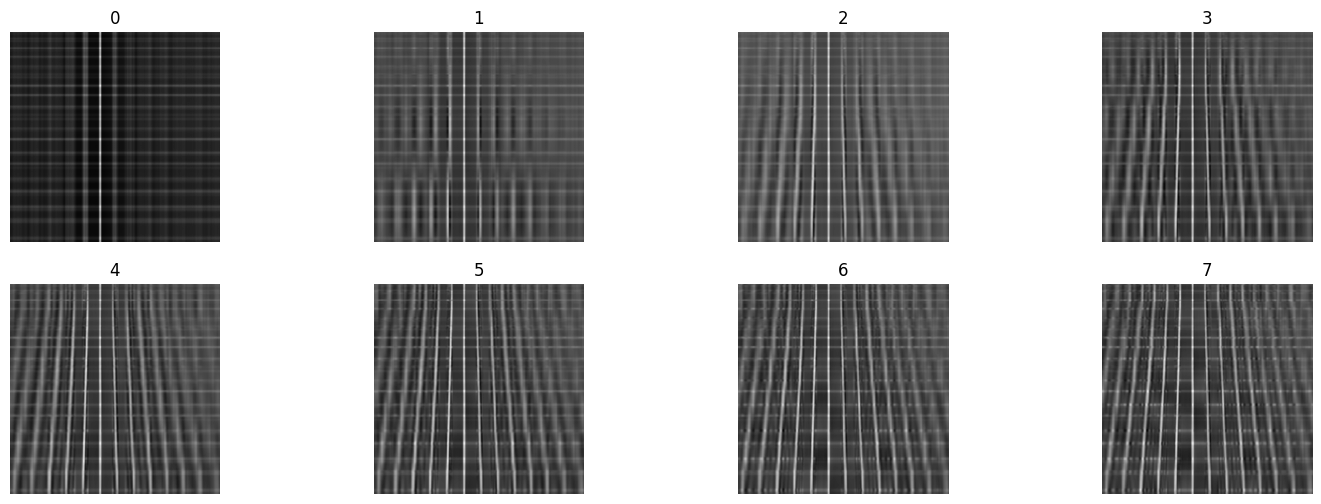

In [8]:
# Visualize the k-rank approximation of X for different values of k
k_rank_approximations = [dyads[0]]
for i in range(len(dyads)-1):
    k_rank_approximations.append(np.sum([k_rank_approximations[i], dyads[i+1]], axis=0))

# plot a few of them
_, axs = plt.subplots(2, 4, figsize=(18, 6))
axs = axs.flatten()
for i, (k_approx, ax) in enumerate(zip(k_rank_approximations, axs)):
    ax.imshow(k_approx, cmap='gray')
    ax.axis('off')
    ax.set_title(i)
plt.show()

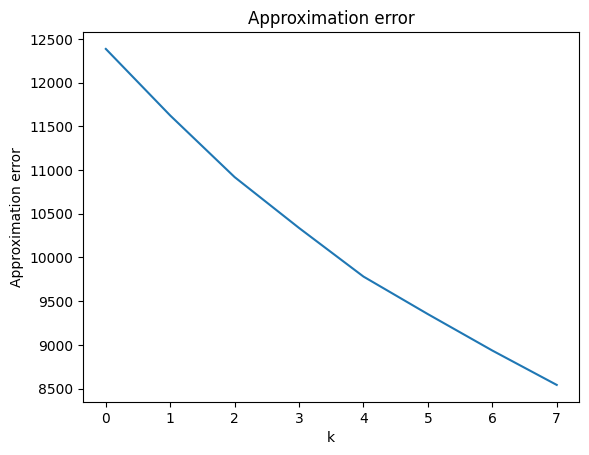

In [9]:
# Compute and plot the approximation error ||X − Xk||F for increasing values of k, where Xk is the k-rank approximation of k
approximation_error = [np.linalg.norm(X-k_approx) for k_approx in k_rank_approximations]
plt.plot(approximation_error)
plt.title("Approximation error")
plt.xlabel("k")
plt.ylabel("Approximation error")
plt.show()

# the error decrease increasing k

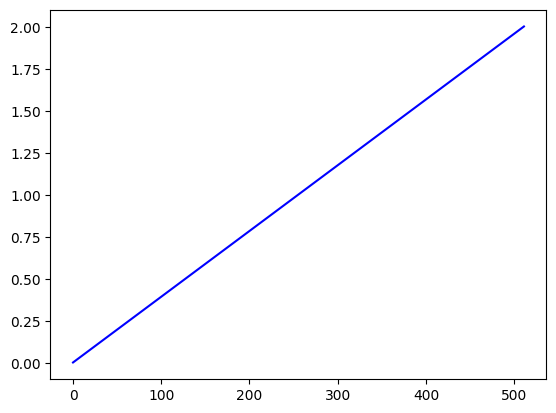

In [10]:
# Plot the compression factor ck = k(m+n+1)/mn for increasing k
c_k = [(k*(1+U.shape[0]+VT.shape[1])) / (U.shape[0]*VT.shape[1]) for k in range(1,len(s)+1)]

plt.plot(c_k, color="blue")
plt.show()

In [11]:
# What is the approximation error when the compressed image requires the same amount of informations of those of the uncompressed image?
c_k = 1
k = round(c_k * (U.shape[0]*VT.shape[1])/(1+U.shape[0]+VT.shape[1]))
print(k)

Xk = np.zeros_like(X, dtype=np.float64)

for i in range(k):
    Xk += k_dyad(U, s, VT, i)
    
print(np.linalg.norm(X- Xk))


256
231.51158241636546


### Classification of MNIST Digits with SVD Decomposition.

In [12]:
import scipy.io
np.random.seed(42)

mnist_data = scipy.io.loadmat('MNIST.mat')

X = mnist_data['X']

I = mnist_data['I'] 

print("Shape of X:", X.shape)
print("Shape of I:", I.shape)

Shape of X: (256, 1707)
Shape of I: (1, 1707)


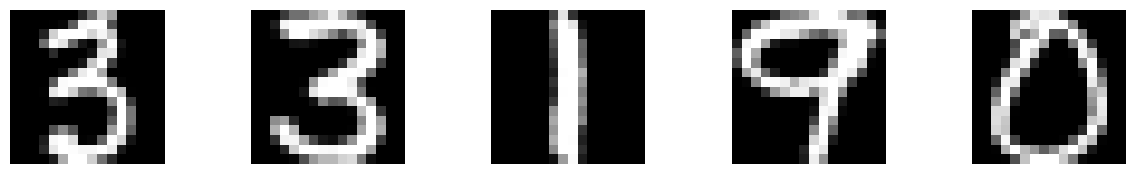

In [13]:
num_datapoints = 5
indices_to_display = np.random.choice(X.shape[1], num_datapoints, replace=False)

# Plot the selected datapoints
fig, axes = plt.subplots(1, num_datapoints, figsize=(15, 2))

for i, index in enumerate(indices_to_display):
    image_data = X[:, index].reshape(16, 16)  # Reshape the flattened data to a 16x16 image
    axes[i].imshow(image_data, cmap='gray')
    axes[i].axis('off')  # Turn off axis labels

plt.show()

In [14]:
idx = np.where((I[0][:]==3) | (I[0][:]==4))[0]

X = X[:, idx]  
I = I[:,idx]

print(f"X shape: {X.shape}") 
print(f"I shape: {I.shape}")




X shape: (256, 253)
I shape: (1, 253)


In [15]:
train_split = 0.75
Ntrain = round(X.shape[1]*train_split)

def train_test_split(X, I, Ntrain):
    N = X.shape[1]

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = I[:, train_idx]

    Xtest = X[:, test_idx]
    Ytest = I[:, test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)


(Xtrain, Ytrain), (Xtest, Ytest) = train_test_split(X, I, Ntrain)

print("Xtrain shape = {}\nXtest shape = {}".format(Xtrain.shape, Xtest.shape))
print("Ytrain shape = {}\nYtest shape = {}".format(Ytrain.shape, Ytest.shape))

Xtrain shape = (256, 190)
Xtest shape = (256, 63)
Ytrain shape = (1, 190)
Ytest shape = (1, 63)


In [16]:
# X1 for C1 = '3'   X2 for C2 = '4'
X1, X2 = Xtrain[:,np.where(Ytrain[0][:]==3)[0]], Xtrain[:,np.where(Ytrain[0][:]==4)[0]]

print(X1.shape,X2.shape)

U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)


(256, 96) (256, 94)


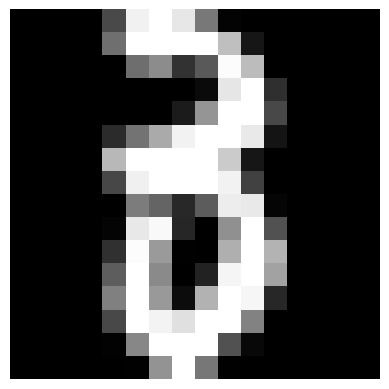

(256,)


In [17]:
# take an unknown digit y from the test set
np.random.seed(42)

i = np.random.choice(Xtest.shape[1], 1)
image_data = Xtest[:, i].reshape(16, 16)  # Reshape the flattened data to a 16x16 image
plt.imshow(image_data, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

y = Xtest[:, i].flatten()
print(y.shape)

y1 = U1 @ (U1.T @ y)
y2 = U2 @ (U2.T @ y)


In [18]:
d1 = np.linalg.norm(y - y1, 2)
d2 = np.linalg.norm(y - y2, 2)

if d1 < d2:
    print('The class of y is C1 : 3')
if d2 < d1:
    print('The class of y is C2 : 4')

The class of y is C1 : 3


In [19]:
# algorithm with Misclassification error
mislassification = 0

for i in range(Xtest.shape[1]):
    y = Xtest[:,i]
    y1 = U1 @ (U1.T @ y)
    y2 = U2 @ (U2.T @ y)

    d1 = np.linalg.norm(y - y1, 2)
    d2 = np.linalg.norm(y - y2, 2)

    if d1 < d2:
        if Ytest[:,i] == 4:
            mislassification += 1
    if d2 < d1:
        if Ytest[:,i] == 3:
            mislassification += 1

print(mislassification)



0


In [20]:
# Repeat the experiment for different digits other than 3 or 4

mnist_data = scipy.io.loadmat('MNIST.mat')
X = mnist_data['X']
I = mnist_data['I'] 

result = {}

unique_values = np.unique(I)
print("Valori unici di I:", unique_values)


for i in range(10):
    for j in range(i+1,10):
        result[(i,j)] = 0
        idx = np.where((I[0][:]==i) | (I[0][:]==j))[0]
        x = X[:, idx]  
        y = I[:,idx]
        (Xtrain, Ytrain), (Xtest, Ytest) = train_test_split(x, y, Ntrain)
        X1, X2 = Xtrain[:,np.where(Ytrain[0][:]==i)[0]], Xtrain[:,np.where(Ytrain[0][:]==j)[0]]
        U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
        U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)

        for k in range(Xtest.shape[1]):
            y = Xtest[:,k]
            y1 = U1 @ (U1.T @ y)
            y2 = U2 @ (U2.T @ y)

            d1 = np.linalg.norm(y - y1, 2)
            d2 = np.linalg.norm(y - y2, 2)

            if d1 < d2:
                if Ytest[:,k] == j:
                    result[(i,j)] += 1
            if d2 < d1:
                if Ytest[:,k] == i:
                    result[(i,j)] += 1
   


Valori unici di I: [0 1 2 3 4 5 6 7 8 9]


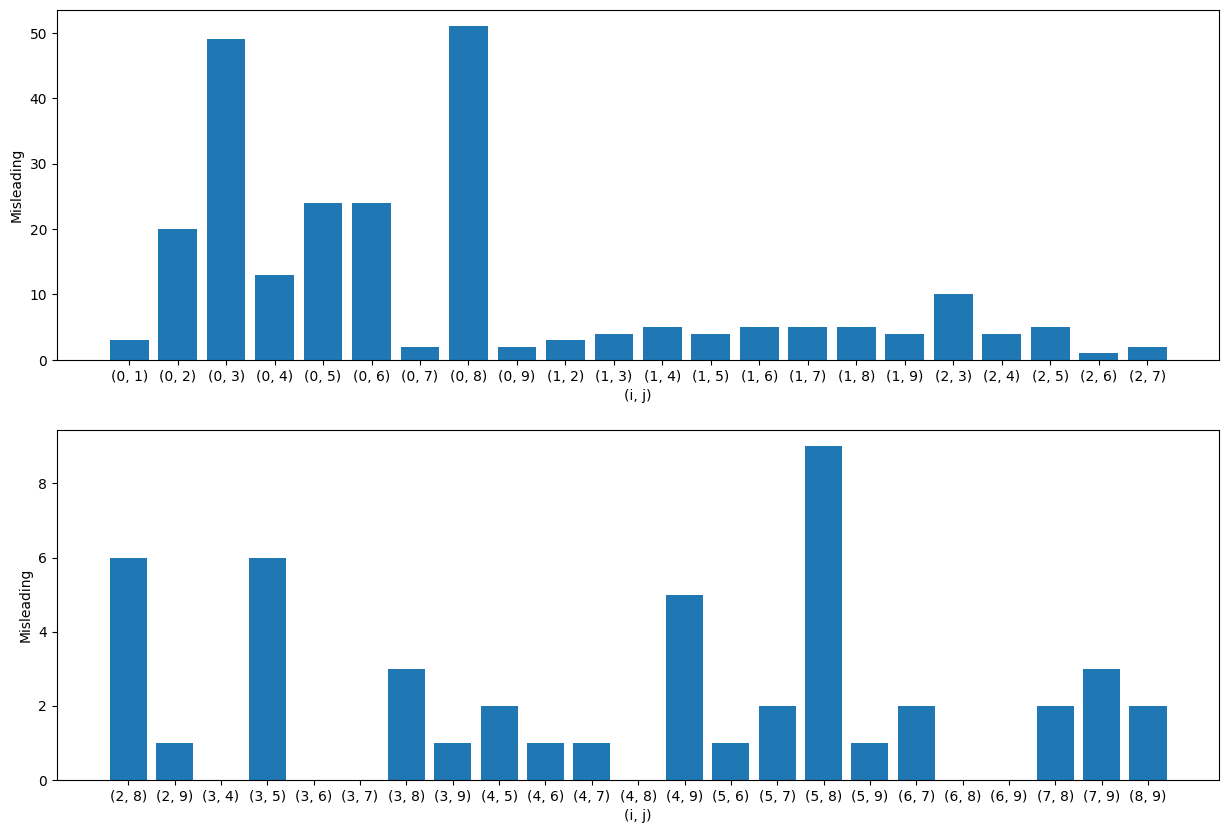

In [21]:
keys = list(result.keys())
values = list(result.values())

formatted_keys = [f'({key[0]}, {key[1]})' for key in keys]

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].bar(formatted_keys[:len(formatted_keys)//2], values[:len(values)//2])
ax[0].set_xlabel('(i, j)')
ax[0].set_ylabel('Misleading')

ax[1].bar(formatted_keys[len(formatted_keys)//2:], values[len(values)//2:])
ax[1].set_xlabel('(i, j)')
ax[1].set_ylabel('Misleading')

plt.show()

Il massimo misleading c'è quando la classificazione è tra il digit = 0 o 5

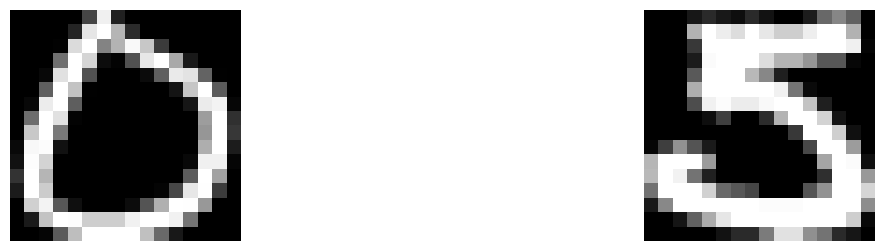

In [22]:
idx = np.where((I[0][:]==0))[0]
X0 = X[:, idx] 
idx = np.where((I[0][:]==5))[0]
X5 = X[:, idx]

image_data0 = X0[:, 0].reshape(16, 16)  
image_data5 = X5[:, 0].reshape(16, 16)

_, ax = plt.subplots(1, 2, figsize = (15, 3))
ax[0].imshow(image_data0, cmap='gray')
ax[0].axis('off')
ax[1].imshow(image_data5, cmap='gray')
ax[1].axis('off')
plt.show()


As we can see we can notice the similarities between the two images

In [23]:
# Repeat the experiment with 3 digit Classes
result = {}

for i in range(10):
    for j in range(i+1,10):
        for k in range(j+1,10):
            result[(i,j,k)] = 0
            idx = np.where((I[0][:]==i) | (I[0][:]==j) | (I[0][:]==k))[0]
            x = X[:, idx]  
            y = I[:,idx]
            (Xtrain, Ytrain), (Xtest, Ytest) = train_test_split(x, y, Ntrain)
            X1, X2, X3= Xtrain[:,np.where(Ytrain[0][:]==i)[0]], Xtrain[:,np.where(Ytrain[0][:]==j)[0]], Xtrain[:,np.where(Ytrain[0][:]==k)[0]]
            U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
            U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)
            U3, s3, VT3 = np.linalg.svd(X3, full_matrices=False)

            for c in range(Xtest.shape[1]):
                y = Xtest[:,c]
                y1 = U1 @ (U1.T @ y)
                y2 = U2 @ (U2.T @ y)
                y3 = U3 @ (U3.T @ y)

                d1 = np.linalg.norm(y - y1, 2)
                d2 = np.linalg.norm(y - y2, 2)
                d3 = np.linalg.norm(y - y3, 2)

                if d1 < d2 and d1 < d3:
                    if Ytest[:,c] == j or Ytest[:,c] == k:
                        result[(i,j,k)] += 1
                if d2 < d1 and d2 < d3:
                    if Ytest[:,c] == i or Ytest[:,c] == k:
                        result[(i,j,k)] += 1
                if d3 < d1 and d3 < d2:
                    if Ytest[:,c] == j or Ytest[:,c] == i:
                        result[(i,j,k)] += 1


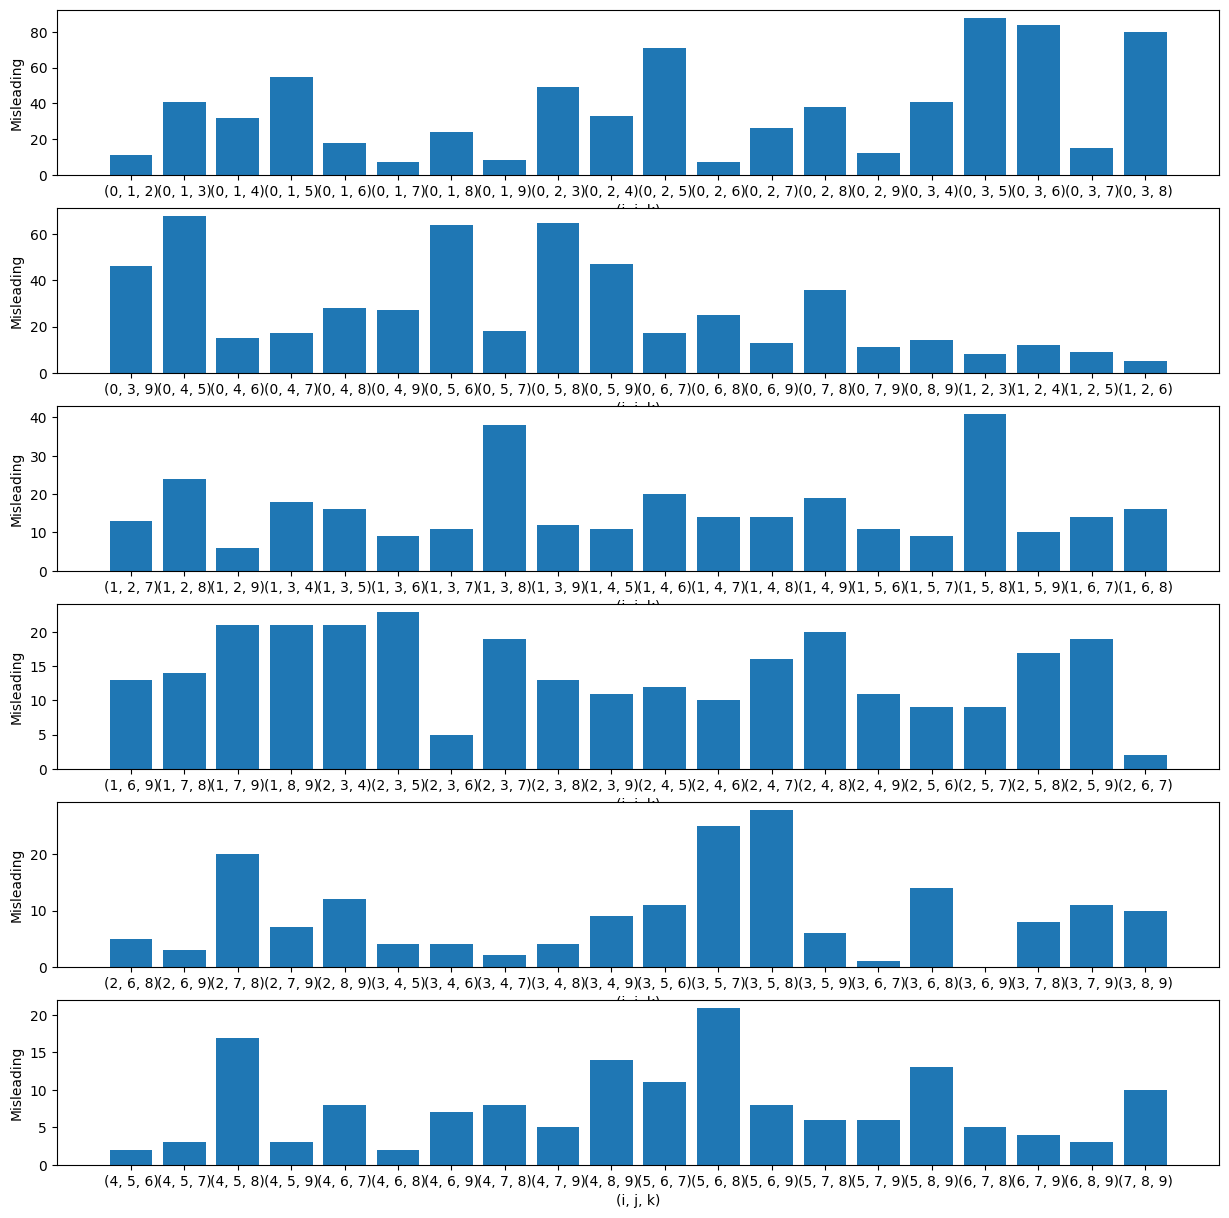

In [24]:
keys = list(result.keys())
values = list(result.values())

formatted_keys = [f'({key[0]}, {key[1]}, {key[2]})' for key in keys]

fig, ax = plt.subplots(6, 1, figsize=(15, 15))

# Numero di divisioni
num_divisions = 6

for i in range(num_divisions):
    start_idx = int(i * len(formatted_keys) / num_divisions)
    end_idx = int((i + 1) * len(formatted_keys) / num_divisions)
    
    ax[i].bar(formatted_keys[start_idx:end_idx], values[start_idx:end_idx])
    ax[i].set_xlabel('(i, j, k)')
    ax[i].set_ylabel('Misleading')

plt.show()




Overall the errors increase

### Clustering with PCA

In [25]:
# Load data into memory
data = pd.read_csv('data.csv')
np.random.seed(42)

In [26]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Inspect the data: il dataset è composto da 42000 immagini di numeri handwritten, l'immagini sono 28x28 pixel, su ogni riga del dataset 
# abbiamo la label che ci indica il numero scritto a mano e i suoi 784 pixel totali
print(f"Shape of the data: {data.shape}")

Shape of the data: (42000, 785)


Ci sono 784 (dallo 0 a 783) pixel, la prima colonna 0 di data è il label che indica qual'è il valore scritto a mano.

In [28]:
Y = np.array(data['label'])
X = np.array(data.drop('label', axis=1).T)
print(X.shape, Y.shape)
d, N = X.shape

(784, 42000) (42000,)


In [29]:
idx = np.where((Y[:]==3) | (Y[:]==6) | (Y[:]==7))[0]

X = X[:, idx]  
Y = Y[idx]

print(f"X shape: {X.shape}") 
print(f"Y shape: {Y.shape}")

print("Kept samples choosing indeces {}: {:.2f}%".format(
    [3,6,7],
    X.shape[1]/N*100
))

X shape: (784, 12889)
Y shape: (12889,)
Kept samples choosing indeces [3, 6, 7]: 30.69%


In [30]:
train_split = 0.75
Ntrain = round(X.shape[1]*train_split)

def train_test_split(X, Y, Ntrain):
    N = X.shape[1]

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)


(Xtrain, Ytrain), (Xtest, Ytest) = train_test_split(X, Y, Ntrain)

print("Xtrain shape = {}\nXtest shape = {}".format(Xtrain.shape, Xtest.shape))
print("Ytrain shape = {}\nYtest shape = {}".format(Ytrain.shape, Ytest.shape))

Xtrain shape = (784, 9667)
Xtest shape = (784, 3222)
Ytrain shape = (9667,)
Ytest shape = (3222,)


Centroid of Xc is : 1.8656162323041907e-12.
Projected dataset shape: (2, 9667)


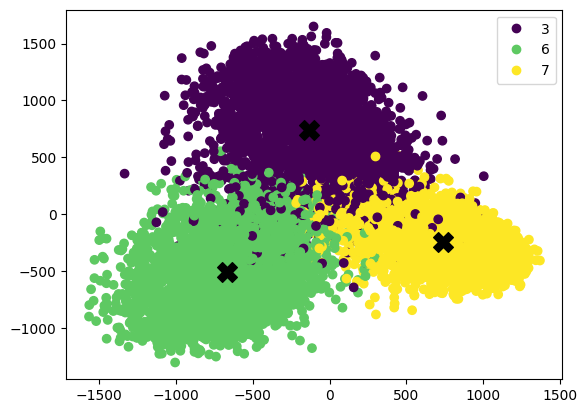

In [31]:
def centroid(X):
    return np.mean(X, axis=1, keepdims=True) 

# set the dimensionality of the reduction
k = 2
# with k = 2 is it possible to visualize clusters in Python

def PCA(X, k):
    c =  centroid(X)
    Xc = X - c 
    U, S, VT = np.linalg.svd(Xc, full_matrices=False)
    U_k = U[:, :k]
    return U_k.T

# Z is the projected dataset
# the projected space, the columns of Z are the principal component of X
Xc = Xtrain - centroid(Xtrain)
print(f"Centroid of Xc is : {np.linalg.norm(centroid(Xc))}.")
Z = PCA(Xtrain, k) @ Xc 
print("Projected dataset shape: {}".format(Z.shape))

scatter = plt.scatter(Z[0, :], Z[1,:], c = Ytrain) 

# Compute and plot the centroids
centroids = np.array([centroid(Z[:, Ytrain == label]) for label in np.unique(Ytrain)])
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')

plt.legend(handles=scatter.legend_elements()[0], labels=[str(y) for y in np.unique(Y)])
plt.show()


In [32]:
# Compute, for each cluster, the average distance from the centroid. Comment the result;
# Compute, for each cluster, the average distance from the centroid on the test set. Comment the results;

def average_distance_to_centroids(Z, Ytrain):
    unique_labels = np.unique(Ytrain)
    distances = []

    for label in unique_labels:
        cluster_points = Z[:, Ytrain == label]
        centroid = np.mean(cluster_points, axis=1, keepdims=True)
        distance_to_centroid = np.linalg.norm(cluster_points - centroid, axis=0)
        average_distance = np.mean(distance_to_centroid)
        distances.append(average_distance)

    return distances

d_train = average_distance_to_centroids(Z,Ytrain)

print("Distance from centroid train set: ")
print(f"Average distance from centroid for digit {np.unique(Ytrain)[0]} = {d_train[0]}")
print(f"Average distance from centroid for digit {np.unique(Ytrain)[1]} = {d_train[1]}")
print(f"Average distance from centroid for digit {np.unique(Ytrain)[2]} = {d_train[2]}")



Distance from centroid train set: 
Average distance from centroid for digit 3 = 420.6643185946543
Average distance from centroid for digit 6 = 404.89011387066427
Average distance from centroid for digit 7 = 308.7183232298666


The "7" cluster is more compact as we can see in the graph and the average distance is the least

In [33]:
# for the test
Xc_test = Xtest - centroid(Xtest)
Z_test = PCA(Xtrain, k) @ Xc_test 

d_test = average_distance_to_centroids(Z_test,Ytest)
print("Distance from centroid of test set: ")
print(f"Average distance from centroid for digit {np.unique(Ytrain)[0]} = {d_test[0]}")
print(f"Average distance from centroid for digit {np.unique(Ytrain)[1]} = {d_test[1]}")
print(f"Average distance from centroid for digit {np.unique(Ytrain)[2]} = {d_test[2]}")

Distance from centroid of test set: 
Average distance from centroid for digit 3 = 415.50527448119226
Average distance from centroid for digit 6 = 410.05909586020124
Average distance from centroid for digit 7 = 309.1405261361121


The average distance is very similar to the average distance of the train set

In [34]:
# Define a classification algorithm in this way: given a new observation x, compute the distance between
# x and each cluster centroid. Assign x to the class corresponding the the closer centroid. Compute the
# accuracy of this algorithm on the test set and compute its accuracy;

def classify_sample(sample, centroids, classes):
    distances = [np.linalg.norm(sample-c) for c in centroids]
    return classes[np.argmin(distances)]

def get_accuracy(Ztrain, Ztest, Ytrain, Ytest):
    classes = np.unique(Ytrain)
    centroids = []
    for i in classes:
        cluster = Ztrain[:, (Ytrain==i)]
        centroids.append(np.mean(cluster, axis=1))

    correct_predictions = 0

    for sample, c in zip(Ztest.T, Ytest):
        predicted_class = classify_sample(sample, centroids, classes)
        if predicted_class == c:
            correct_predictions += 1

    return correct_predictions / len(Ytest) 


In [35]:
print(f"digit[0] = 3, digit[1] = 6, digit[2] = 7 and k=2 the accuracy obtained is: {get_accuracy(Z, Z_test, Ytrain,Ytest)*100:.2f}%")

digit[0] = 3, digit[1] = 6, digit[2] = 7 and k=2 the accuracy obtained is: 95.56%


In [42]:
# Repeat this experiment for different values of k and different digits.

Y = np.array(data['label'])
X = np.array(data.drop('label', axis=1).T)
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

digit_values = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
result = {}

for k in k_values:
    for digits in digit_values:

        if tuple(digits) not in result:
            result[tuple(digits)] = {}
        idx = np.where(np.isin(Y, digits))[0]
        x = X[:, idx]  
        y = Y[idx]

        (Xtrain, Ytrain), (Xtest, Ytest) = train_test_split(x, y, round(x.shape[1]*train_split))
        Xc_train = Xtrain - centroid(Xtrain)
        Z_train = PCA(Xtrain, k) @ Xc_train

        Xc_test = Xtest - centroid(Xtest)
        Z_test = PCA(Xtrain, k) @ Xc_test 

        accuracy = get_accuracy(Z_train, Z_test, Ytrain,Ytest)*100

        result[tuple(digits)][k] = accuracy


In [43]:
result

{(0, 1, 2): {2: 90.94827586206897,
  3: 92.42610837438424,
  4: 93.75,
  5: 92.42610837438424,
  6: 93.25738916256158,
  7: 94.18103448275862,
  8: 92.88793103448276,
  9: 93.4729064039409,
  10: 93.59605911330048},
 (0, 1, 3): {2: 93.01336573511543,
  3: 94.10692588092346,
  4: 93.86391251518833,
  5: 94.95747266099636,
  6: 95.0789793438639,
  7: 94.47144592952613,
  8: 94.89671931956258,
  9: 95.0789793438639,
  10: 95.74726609963548},
 (0, 2, 3): {2: 84.77093206951027,
  3: 89.66824644549763,
  4: 89.92101105845181,
  5: 90.26856240126382,
  6: 89.92101105845181,
  7: 91.53238546603475,
  8: 91.37440758293839,
  9: 92.13270142180095,
  10: 90.99526066350711},
 (1, 2, 3): {2: 85.95216469875871,
  3: 87.7989706327581,
  4: 90.49349076597034,
  5: 89.61550105964274,
  6: 91.67423554344535,
  7: 90.28156221616712,
  8: 91.61368452921586,
  9: 91.06872540115047,
  10: 90.4026642446261}}

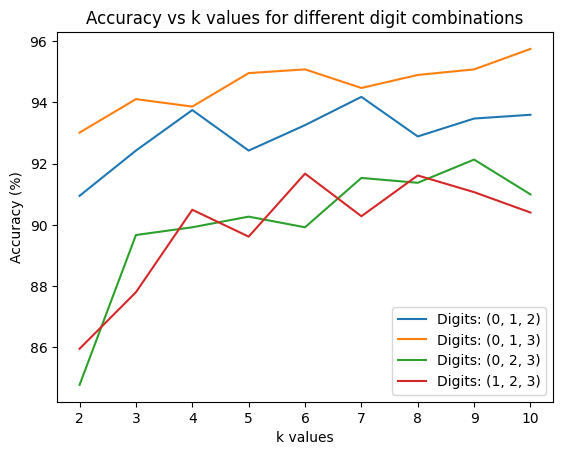

In [44]:
for digits, k_values_dict in result.items():
    k_values = list(k_values_dict.keys())
    accuracies = list(k_values_dict.values())
    
    plt.plot(k_values, accuracies, label=f'Digits: {digits}')

plt.xlabel('k values')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs k values for different digit combinations')
plt.show()


The increase in with k bigger is not monotonic

In [45]:
Y = np.array(data['label'])
X = np.array(data.drop('label', axis=1).T)
k_values = [2, 5, 10, 20]

digit_values = [[2, 3],[1, 7],[0, 6, 9],[1, 4, 5, 8],[0, 1, 2, 3, 4, 5, 6]]
result = {}

for k in k_values:
    for digits in digit_values:

        if tuple(digits) not in result:
            result[tuple(digits)] = {}
        idx = np.where(np.isin(Y, digits))[0]
        x = X[:, idx]  
        y = Y[idx]

        (Xtrain, Ytrain), (Xtest, Ytest) = train_test_split(x, y, round(x.shape[1]*train_split))
        Xc_train = Xtrain - centroid(Xtrain)
        Z_train = PCA(Xtrain, k) @ Xc_train

        Xc_test = Xtest - centroid(Xtest)
        Z_test = PCA(Xtrain, k) @ Xc_test 

        accuracy = get_accuracy(Z_train, Z_test, Ytrain,Ytest)*100

        result[tuple(digits)][k] = accuracy


In [47]:
result

{(2, 3): {2: 89.6810506566604,
  5: 91.88555347091932,
  10: 92.02626641651031,
  20: 92.7298311444653},
 (1, 7): {2: 96.08102157639806,
  5: 96.03698811096433,
  10: 96.4332892998679,
  20: 96.25715543813298},
 (0, 6, 9): {2: 83.94348105330765,
  5: 94.3159922928709,
  10: 95.7931920359666,
  20: 96.0179833012203},
 (1, 4, 5, 8): {2: 71.83437650457391,
  5: 85.91718825228696,
  10: 89.52816562349543,
  20: 89.74482426576793},
 (0, 1, 2, 3, 4, 5, 6): {2: 55.86752078506202,
  5: 75.26236881559221,
  10: 80.9322611421562,
  20: 84.32601880877742}}

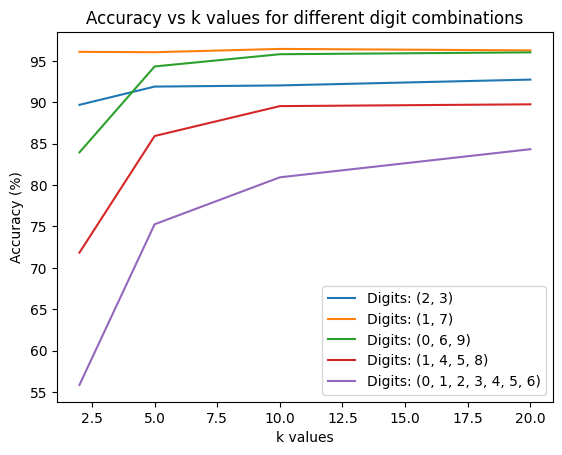

In [48]:
for digits, k_values_dict in result.items():
    k_values = list(k_values_dict.keys())
    accuracies = list(k_values_dict.values())
    
    plt.plot(k_values, accuracies, label=f'Digits: {digits}')

plt.xlabel('k values')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs k values for different digit combinations')
plt.show()


Separation with more digits is really difficult as the datapoints are mixed, so we need more dimensions  to create an effective separation

It's clear that we need more dimensions increasing the digits to classify